<a href="https://colab.research.google.com/github/hiid0726/DeepLearning/blob/main/hiid0726/ch09_DL_04_CNN_ym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 모델 구현하기

* CNN 모델은 컨볼루션, 풀링, 드롭아웃, 그리고 일반적인 신경망 계층의 조합으로 이루어짐

## 환경설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# USE_CUDA, DEVICE
USE_CUDA = torch.cuda.is_available() # 계산을 가속해주는 CUDA를 쓸 수 있는지 확인
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") # CUDA 사용 가능 여부에 따라, 데이터를 CUDA(GPU) 혹은 CPU로 보낼지 결정

In [3]:
print(USE_CUDA, DEVICE)

True cuda


In [3]:
# 에포크, 배치 크기 - 하이퍼 패러미터
EPOCHS = 40
BATCH_SIZE = 64

# 학습용과 테스트용 데이터셋 불러오기
* 코드를 간결하게 하기 위해서 Fashion MNIST 데이터셋을 DataLoader를 부를 때 바로 정의
* transfroms를 이용한 전처리 → 파이토치 텐서화, 정규화 진행

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [5]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)

(3, 224, 224)


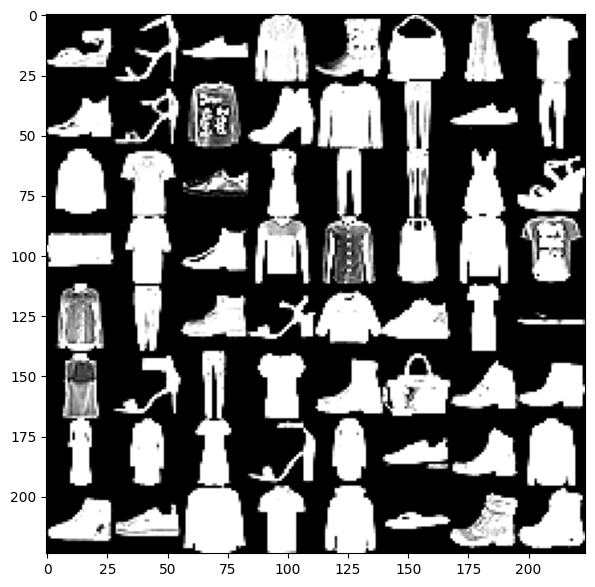

In [6]:
images, labels = next(dataiter)

img = utils.make_grid(images, padding=0)
npimg = img.numpy()
print(npimg.shape)
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

## 신경망 만들기

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CNN 모델 -> 커널 크기 5x5이고, 컨볼루션 계층은 2개
        # nn.Conv2d 모듈 -> 입력 x를 받는 함수
        # self.conv1, self.conv2 -> CNN 모델의 내부 변수(속성)들은 함수로 취급

        self.conv1 = nn.Conv2d(1,10, kernel_size = 5)# 1개의 색상 차원이 10개의 특징 맵을 생성
        # nn.Conv2d(입력 채널 수, 출력 채널 수)
        # 필터(커널) 크기 = kernel_size로 지정 -> 숫자 하나만 지정하면 정사각형으로 간주
        # (3, 5) -> 이런 모양을 입력하면 해당 모양의 직사각형 필터도 가능.
        # 이미지들은 색상으로 input 값을 받음. (흑백 이미지 = 1개)
        
        self.conv2 = nn.Conv2d(10,20, kernel_size = 5)
        # 10개의 특징 맵(conv1)을 받아서 20개의 특징 맵을 만듦

        # 컨볼루션 결과값 -> 출력값. dropout (특정한 가중치에 편중되지 않게, 과적합 막기 위해)
        self.conv2_drop = nn.Dropout2d()

        # --- -> 특징을 추려내는 과정 / 특징을 통해서 분류를 실행

        # 컨볼루션 & 드롭아웃은 거친 이미지 -> 일반 신경망
        # 첫 신경망 계층 -> 앞 계층의 출력 크기인 320을 입력 크기, 출력 크기 50.
        # 20 x 4 x 4 -> 320 -> 50
        self.fc1 = nn.Linear(20 * 4 * 4, 50) # 320 = 20 * 4 * 4 ////320->50

        # 두번째 계층 -> 앞 계층의 출력 크기인 50을 입력 크기, 출력을 분류할 클래스 개수인 10개로 설정
        # 각 계층의 출력 크기는 줄어들기만 하면 됨 (적당히)
        self.fc2 = nn.Linear(50,10)
    
    def forward(self, x): # 데이터 흐름 정의
        # 입력 x를 받아서 컨볼루션 계층(1번째)을 거치게 한 후, 최대풀링을 진행
        # self.conv1을 거쳐서 -> F.max_pool2d(특징맵, 커널 크기) -> 학습 파라미터 없음 nn? F?
        # 활성화 함수 F.relu 거치도록
        # print(x.shape) # 1, 28, 28 # 컨볼루션의 커널 사이즈, -1만큼은 이미지가 축소=> 특징 10개를 가지는 (28-4) 24*24 이미지
        
        # x = self.conv1(x)
        # x = F.max_pool2d(x, 2) #풀링, 커널 사이즈 = 2*2
        # x = F.relu(x)
        x= F.relu(F.max_pool2d(self.conv1(x), 2)) # 위 3줄을 1줄로 표현
        # before pooling: 10, 24, 24
        # pooling : 10, 12, 12
        # print(x.shape)

        # 이 과정을 2번째 컨볼루션 계층에도 반복
        # conv2_drop을 통해서 drop 추가
        x= F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # before pooling: : 20, 8, 8
        # pooling : 20, 4, 4
        # print(x.shape)

        # 특징 맵 -> 1차원으로 펴주기 (view)
        x = x.view(-1, 20 * 4 * 4)# -1 남는 차원 모두. 320개는 원소 개수.
        # print(x.shape)

        # 분류 신경망 구성
        # 1번째 신경망
        x = F.relu(self.fc1(x))# 320 -> 50
        # print(x.shape)
        # 드롭아웃
        
        x = F.dropout(x, training = self.training)# 훈련모드일 때만 dropout
        # 마지막 계층 (0-9까지의 레이블을 갖는 10개의 출력값을 가지는 신경망)
        x = self.df2(x)
        return x

In [10]:
# CNN 모델의 인스턴스와 최적화 함수 생성
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [ ]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [11]:
from torchsummary import summary as summary_ # 모델의 구조를 확인

summary_(model, (1,28,28), batch_size=64)

AttributeError: ignored

In [12]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch): # 모델, 훈련 데이터셋, 최적화 함수, 에포크 차수
    # 모델을 train 모드 -> dropout 활성화
    # 데이터셋에서 배치를 가져와 모델에서 출력값을 뽑음
    for batch_idx, (data, target) in enumerate(train_loader): # 데이터 로더의 인덱스(배치별), 그 값
    # 그 값 -> data, 라벨
        data, target = data.to(DEVICE), target.to(DEVICE)# 텐서들 -> 모델과 연결된 장치로 보내주기
        optimizer.zero_grad() # 배치 돌 때마다 기울기값(최적화) 리셋
        output= model(data)# 모델을 거친 데이터 -> output
        loss = F.cross_entropy(output, target)# 크로스 엔트로피 오차 함수로 오차값 계산
        # 예측값과 정답값 사이의 교차 엔트로피 -> 손실(에러) 계산
        loss.backward() # 오차역전파 -> 미분계수 전달
        optimizer.step() # 모델의 학습 패러미터 갱신 / 가중치 (conv도 갱신, linear 갱신)

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [13]:
# 성능 확인 코드
def evaluate(model, test_loader):
    model.eval() # 평가 모드
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output= model(data)
            
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepidm = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [14]:
# DNN으로 구현했던 FashionMNIST를 CNN으로 개선
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

AttributeError: ignored